# Pfizer Stock Price Prediction: Attempt 1 - Foundational Model

## 1. Environment Setup

This project uses Python for data analysis and machine learning. Key libraries include:

*   **pandas & numpy:** For data manipulation and numerical computations.
*   **scikit-learn:** For machine learning models and evaluation.
*   **matplotlib & seaborn:** For data visualization.
*   **yfinance:** To download historical stock market data.

Analysis is conducted within a dedicated virtual environment (`pfizer_env`) for dependency management.

In [1]:

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt # For plotting 
import seaborn as sns # For styling plots 

# Set plotting style
sns.set(style="darkgrid")


# 2. Data Extraction and Preprocessing

### 2.1. Data Source and Acquisition
Pfizer (PFE) stock data is downloaded using `yfinance`, sourcing from Yahoo Finance. The period covers January 1, 2010, to April 16, 2025. We extract 'Open', 'High', 'Low', 'Close', and 'Volume'.

Yahoo Finance is a widely accessible and commonly used source for historical stock data.

In [2]:

ticker = "PFE" 
start_date = "2010-01-01" 
end_date = "2025-04-17" # Fetch one day extra to ensure data up to 2025-04-16 is included

print(f"Downloading {ticker} data from {start_date} to {end_date} (exclusive of end date)")
pf_data = yf.download(ticker, start=start_date, end=end_date)

# Select required column
pf_data = pf_data[['Open', 'High', 'Low', 'Close', 'Volume']]
print("Data downloaded. First 5 rows:")
print(pf_data.head())
print("\nLast 5 rows:")
print(pf_data.tail())
print(f"\nShape of the data: {pf_data.shape}")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Data downloaded. First 5 rows:
Price           Open      High       Low     Close    Volume
Ticker           PFE       PFE       PFE       PFE       PFE
Date                                                        
2010-01-04  9.346310  9.689059  9.330964  9.683944  54898644
2010-01-05  9.678828  9.683944  9.489549  9.545821  45714931
2010-01-06  9.545821  9.622555  9.469086  9.515126  43640975
2010-01-07  9.535590  9.550937  9.443508  9.479318  41557112
2010-01-08  9.525359  9.571399  9.474202  9.556052  32049716

Last 5 rows:
Price            Open       High        Low      Close    Volume
Ticker            PFE        PFE        PFE        PFE       PFE
Date                                                            
2025-04-10  21.843291  21.853104  20.695193  21.185833  72960700
2025-04-11  21.185834  21.588159  20.881638  21.499844  55078100
2025-04-14  21.666660  21.813851  21.460592  21.705912  61900900
2025-04-15  21.754976  22.500749  21.715724  22.019922  51814700
2025-04-16  

### 2.2. Initial Data Cleaning & Preparation
A preliminary check for missing values (NaNs) is performed. If `yfinance` returns columns as a MultiIndex (e.g., `('Close', 'PFE')`), they are flattened for easier use (e.g., to just `Close`).


In [3]:
import pandas as pd
import numpy as np

print("\nChecking for missing values (NaNs):")
print(pf_data.isnull().sum())

# If missing values were present, a common strategy is forward-fill:
# pf_data.fillna(method='ffill', inplace=True)
# print("\nMissing values after forward-fill:")
# print(pf_data.isnull().sum())

# Verify date range
print(f"\nData starts on: {pf_data.index.min()}")
print(f"Data ends on: {pf_data.index.max()}")

# Flatten MultiIndex columns if present
if isinstance(pf_data.columns, pd.MultiIndex):
    print(f"Original pf_data columns (MultiIndex): {pf_data.columns.tolist()}")
    pf_data.columns = pf_data.columns.get_level_values(0)
    print(f"Flattened pf_data columns: {pf_data.columns.tolist()}")
else:
    print("pf_data columns are already single-level. No flattening applied.")

# Save the raw downloaded data
pf_data.to_csv("PFE_stock_data_2010_2025.csv")
print("\nRaw data saved to PFE_stock_data_2010_2025.csv")


Checking for missing values (NaNs):
Price   Ticker
Open    PFE       0
High    PFE       0
Low     PFE       0
Close   PFE       0
Volume  PFE       0
dtype: int64

Data starts on: 2010-01-04 00:00:00
Data ends on: 2025-04-16 00:00:00
Original pf_data columns (MultiIndex): [('Open', 'PFE'), ('High', 'PFE'), ('Low', 'PFE'), ('Close', 'PFE'), ('Volume', 'PFE')]
Flattened pf_data columns: ['Open', 'High', 'Low', 'Close', 'Volume']

Raw data saved to PFE_stock_data_2010_2025.csv


The check confirmed no missing values in OHLCV. If present, forward-fill (`fillna(method='ffill')`) would be a considered strategy to maintain data continuity.

### 2.3. Data Splitting
The dataset is divided chronologically to prevent lookahead bias and allow for robust model evaluation:

*   **Training Set:** Data from 4 January, 2010 up to December 31, 2021. Used for model training. A validation subset will be carved out later.
*   **Out-of-Sample (OOS) Set:** Data from 3rd January, 2022 up to April 16, 2025. Reserved for final,

In [4]:
import pandas as pd

# Define split dates
train_end_date = "2021-12-31"
oos_start_date = "2022-01-01"

# Split the data
train_data = pf_data.loc[:train_end_date]
oos_data = pf_data.loc[oos_start_date:] 

print("--- Data Splitting ---")
if not train_data.empty and not oos_data.empty:
    print(f"Full data range: {pf_data.index.min()} to {pf_data.index.max()}")
    print(f"Training data: {train_data.index.min()} to {train_data.index.max()}, Shape: {train_data.shape}")
    print(f"Out-of-Sample (OOS) data: {oos_data.index.min()} to {oos_data.index.max()}, Shape: {oos_data.shape}")
    assert train_data.index.max() < oos_data.index.min(), "Training and OOS data overlap or are not contiguous!"
    print("Data split verified: No overlap, correct periods.")
else:
    print("Train or OOS data is empty. Check split dates and data range.")

# Store these
train_data.to_csv("PFE_train_data.csv")
oos_data.to_csv("PFE_oos_data.csv")
print("\nTrain and OOS dataframes created and saved.")

--- Data Splitting ---
Full data range: 2010-01-04 00:00:00 to 2025-04-16 00:00:00
Training data: 2010-01-04 00:00:00 to 2021-12-31 00:00:00, Shape: (3021, 5)
Out-of-Sample (OOS) data: 2022-01-03 00:00:00 to 2025-04-16 00:00:00, Shape: (825, 5)
Data split verified: No overlap, correct periods.

Train and OOS dataframes created and saved.


## 2.4. Baseline Strategy: Buy and Hold
A "Buy and Hold" baseline is implemented to benchmark subsequent strategies.

**Methodology:**
Assume a $1,000,000 long position in PFE stock every day.
PnL for day `d` = `DailyReturn_d * $1,000,000`.
`DailyReturn_d = (Close_d - Close_{d-1}) / Close_{d-1}`.

PnL is calculated for the entire dataset and for the OOS period.


**Performance Summary (from output):**
*   **Entire Period ([FILL_FROM_OUTPUT: pf_data_min_date] - 2025-04-16):**
    *   Total Cumulative PnL: `$1,166,858.21`
*   **Out-of-Sample Period ([FILL_FROM_OUTPUT: oos_data_min_date] - 2025-04-16):**
    *   Total Cumulative PnL: `$-734,748.57`

The plots below visualize this performance.

--- Baseline Strategy: Buy and Hold (Entire Period) ---
Price          Close  DailyReturn  Baseline_PnL  Baseline_Cumulative_PnL
Date                                                                    
2010-01-04  9.683944          NaN           NaN                      NaN
2010-01-05  9.545821    -0.014263 -14263.048421            -14263.048421
2010-01-06  9.515126    -0.003216  -3215.539128            -17478.587550
2010-01-07  9.479318    -0.003763  -3763.330341            -21241.917890
2010-01-08  9.556052     0.008095   8094.943704            -13146.974187

Last 5 rows (Entire Period):
Price           Close  DailyReturn  Baseline_PnL  Baseline_Cumulative_PnL
Date                                                                     
2025-04-10  21.185833    -0.040018 -40017.790063             1.145811e+06
2025-04-11  21.499844     0.014822  14821.726408             1.160633e+06
2025-04-14  21.705912     0.009585   9584.629674             1.170217e+06
2025-04-15  22.019922     0.01446

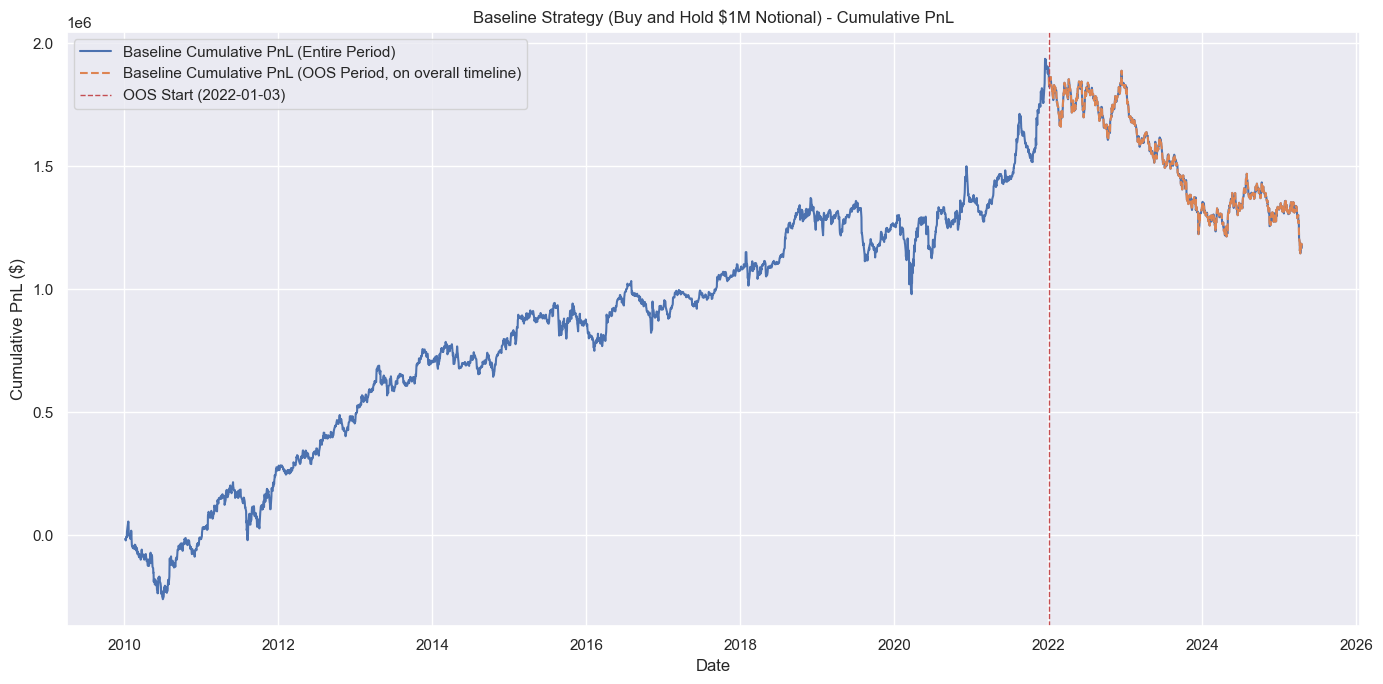

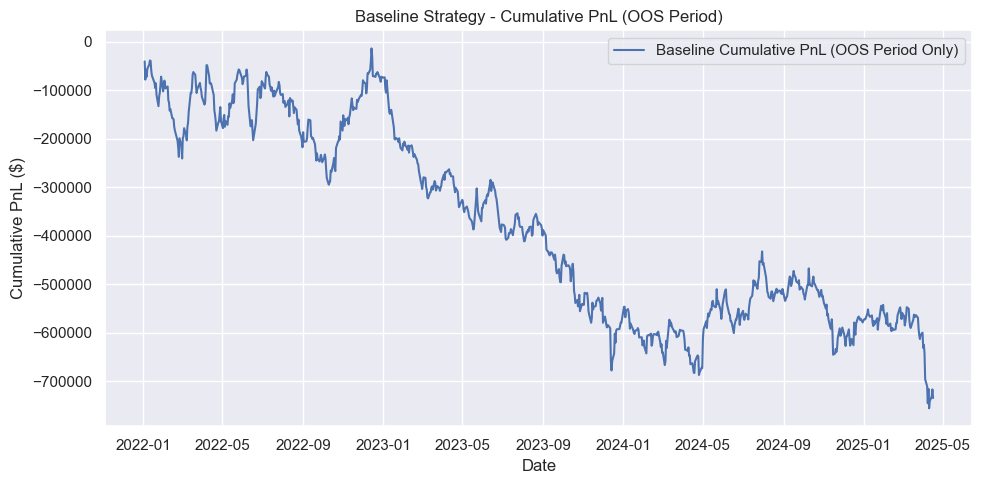


--- Key Performance Indicators for Baseline Strategy ---
Total PnL (Entire Period): $1,166,858.63
Total PnL (OOS Period): $-734,748.71


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

# Calculate Daily Return
pf_data['DailyReturn'] = pf_data['Close'].pct_change()

# Calculate Baseline PnL
investment_amount = 1000000
pf_data['Baseline_PnL'] = pf_data['DailyReturn'] * investment_amount

# Calculate Baseline Cumulative PnL
pf_data['Baseline_Cumulative_PnL'] = pf_data['Baseline_PnL'].cumsum()

# --- Analyze Baseline PnL for the entire period ---
print("--- Baseline Strategy: Buy and Hold (Entire Period) ---")
print(pf_data[['Close', 'DailyReturn', 'Baseline_PnL', 'Baseline_Cumulative_PnL']].head())
print("\nLast 5 rows (Entire Period):")
print(pf_data[['Close', 'DailyReturn', 'Baseline_PnL', 'Baseline_Cumulative_PnL']].tail())

total_pnl_entire_period = pf_data['Baseline_Cumulative_PnL'].iloc[-1] if not pf_data.empty else 0
print(f"\nTotal PnL for Baseline (Entire Period): ${total_pnl_entire_period:,.2f}")

# --- Analyze Baseline PnL for the OOS period ---
# Ensure oos_data index exists and is non-empty
if not oos_data.empty:
    oos_baseline_pnl_data = pf_data.loc[oos_data.index].copy()
    oos_baseline_pnl_data['Baseline_OOS_Cumulative_PnL'] = oos_baseline_pnl_data['Baseline_PnL'].cumsum()

    print("\n--- Baseline Strategy: Buy and Hold (OOS Period Only) ---")
    print(oos_baseline_pnl_data[['Close', 'DailyReturn', 'Baseline_PnL', 'Baseline_OOS_Cumulative_PnL']].head())
    print("\nLast 5 rows (OOS Period):")
    print(oos_baseline_pnl_data[['Close', 'DailyReturn', 'Baseline_PnL', 'Baseline_OOS_Cumulative_PnL']].tail())

    total_pnl_oos_period = oos_baseline_pnl_data['Baseline_OOS_Cumulative_PnL'].iloc[-1] if not oos_baseline_pnl_data.empty else 0
    print(f"\nTotal PnL for Baseline (OOS Period): ${total_pnl_oos_period:,.2f}")
else:
    print("\nWarning: OOS data is empty, cannot calculate OOS baseline PnL details.")
    total_pnl_oos_period = 0 # Default value if oos_data is empty


# --- Visualization ---
plt.figure(figsize=(14, 7))
plt.plot(pf_data.index, pf_data['Baseline_Cumulative_PnL'], label='Baseline Cumulative PnL (Entire Period)')

if not oos_data.empty and not oos_baseline_pnl_data.empty:
    oos_start_actual_date = oos_baseline_pnl_data.index.min()
    # Find PnL at the point OOS starts for correct plotting offset
    if oos_start_actual_date > pf_data.index.min():
        cumulative_pnl_before_oos = pf_data.loc[pf_data.index < oos_start_actual_date, 'Baseline_Cumulative_PnL']
        oos_cumulative_pnl_at_start = cumulative_pnl_before_oos.iloc[-1] if not cumulative_pnl_before_oos.empty else 0
    else: # OOS starts at the beginning of pf_data
        oos_cumulative_pnl_at_start = 0

    plt.plot(oos_baseline_pnl_data.index, oos_baseline_pnl_data['Baseline_OOS_Cumulative_PnL'] + oos_cumulative_pnl_at_start,
             label='Baseline Cumulative PnL (OOS Period, on overall timeline)', linestyle='--')
    plt.axvline(oos_start_actual_date, color='r', linestyle='--', lw=1, label=f'OOS Start ({oos_start_actual_date.date()})')

plt.title('Baseline Strategy (Buy and Hold $1M Notional) - Cumulative PnL')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL ($)')
plt.legend()
plt.tight_layout()
plt.show()

if not oos_data.empty and not oos_baseline_pnl_data.empty:
    plt.figure(figsize=(10, 5))
    plt.plot(oos_baseline_pnl_data.index, oos_baseline_pnl_data['Baseline_OOS_Cumulative_PnL'], label='Baseline Cumulative PnL (OOS Period Only)')
    plt.title('Baseline Strategy - Cumulative PnL (OOS Period)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative PnL ($)')
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\n--- Key Performance Indicators for Baseline Strategy ---")
print(f"Total PnL (Entire Period): ${total_pnl_entire_period:,.2f}")
print(f"Total PnL (OOS Period): ${total_pnl_oos_period:,.2f}")

# 3. Feature Engineering

This step creates input variables (features) from raw stock data for the machine learning model. All features are calculated *without lookahead bias*, using only information available up to day `d` for features on day `d`.

Features aim to capture:
*   **Trend:** Price direction.
*   **Momentum:** Rate of price change.
*   **Volatility:** Magnitude of price fluctuations.
*   **Volume Dynamics:** Trading activity confirming price moves.

## 3.1. Basic Technical Indicators
These are standard indicators chosen for their ability to capture different market facets.

### 3.1.1. Returns
*   **Measures:** Momentum.
*   **Indicators:**
    *   **Daily Return:** `(Close_d - Close_d-1) / Close_d-1`. Captures immediate momentum.
    *   **N-Day Returns (5D, 10D, 21D):** `(Close_d - Close_d-N) / Close_d-N`.
        *   *Rationale for Periods:* 5D (1 week), 10D (2 weeks), 21D (approx. 1 month) capture momentum over varying short to medium terms.

### 3.1.2. Moving Averages (SMA)
*   **Measures:** Trend, support/resistance.
*   **Indicators:**
    *   **SMA_N_Close (10D, 20D, 50D):** Simple Moving Average of closing prices.
        *   *Rationale for Periods:* 10D (short-term trend), 20D (medium-term/monthly), 50D (longer-term/quarterly). These are commonly use indicators.
    *   **SMA_N_Volume (10D, 20D, 50D):** SMA of trading volume.
        *   *Rationale for Periods:* Aligns volume trends with price trends.
    *   **Close_SMA_20_Ratio:** `Close / SMA_20_Close`.
        *   *Rationale:* Price deviation from its medium-term average. Can indicate overbought/sold relative to trend.

### 3.1.3. Moving Average Convergence Divergence (MACD)
*   **Measures:** Trend-following momentum.
*   **Indicators:** MACD Line, Signal Line, MACD Histogram.
    *   *Rationale for Periods (12D EMA, 26D EMA, 9D Signal EMA):* Standard MACD parameters, capturing changes in medium-term trend and providing crossover signals.

### 3.1.4. Relative Strength Index (RSI)
*   **Measures:** Momentum, overbought/oversold conditions.
*   **Indicator:** RSI.
    *   *Rationale for Period (14D):* Standard RSI parameter, balancing responsiveness and smoothness.

### 3.1.5. Bollinger Bands
*   **Measures:** Volatility, relative price levels.
*   **Indicators:** Upper Band, Lower Band, Centerline (20D SMA).
    *   *Rationale for Period (20D SMA, 2 StdDev):* Standard Bollinger parameters. Bands widen/narrow with volatility.
    *   **Bollinger_Bandwidth:** `(Upper_Band - Lower_Band) / SMA_Centerline`. Captures volatility as a percentage.
    *   **Price_Bollinger_Pct:** `(Close - Lower_Band) / (Upper_Band - Lower_Band)`. Normalizes price within bands.

### 3.1.6. Volatility
*   **Measures:** Price risk/fluctuation.
*   **Indicator:** Volatility_ND (10D, 20D): Rolling standard deviation of daily returns (annualized by sqrt(N)).
    *   *Rationale for Periods:* 10D (short-term), 20D (medium-term/monthly) volatility.

### 3.1.7. Volume Indicators
*   **Measures:** Trading activity, conviction.
*   **Indicators:**
    *   **Volume_Change:** Percentage change in daily volume. Captures significant volume deviations.
    *   **Volume_SMA_5_Ratio:** `Volume / SMA_5_Volume`.
        *   *Rationale for Period (5D SMA):* Compares current volume to its weekly average.

In [6]:
import numpy as np
data = pf_data.copy();

# --- 1. Returns ---
print("\nCalculating Returns...")
data['DailyReturn'] = data['Close'].pct_change()
for n in [5, 10, 21]: # 21 days is approx 1 trading month
    data[f'Return_{n}D'] = data['Close'].pct_change(periods=n)

# --- 2. Moving Averages (SMA) ---
print("Calculating Moving Averages...")
for n in [10, 20, 50]:
    data[f'SMA_{n}_Close'] = data['Close'].rolling(window=n).mean()
    data[f'SMA_{n}_Volume'] = data['Volume'].rolling(window=n).mean()

# Ratio of Close to SMA 
data['Close_SMA_20_Ratio'] = data['Close'].squeeze() / data['SMA_20_Close']

# --- 3. Moving Average Convergence Divergence (MACD) ---
print("Calculating MACD...")
ema_short_period = 12
ema_long_period = 26
signal_period = 9
data['EMA_Short_Close'] = data['Close'].ewm(span=ema_short_period, adjust=False).mean()
data['EMA_Long_Close'] = data['Close'].ewm(span=ema_long_period, adjust=False).mean()
data['MACD'] = data['EMA_Short_Close'] - data['EMA_Long_Close']
data['MACD_Signal'] = data['MACD'].ewm(span=signal_period, adjust=False).mean()
data['MACD_Hist'] = data['MACD'] - data['MACD_Signal'] # Histogram part

# --- 4. Relative Strength Index (RSI) ---
print("Calculating RSI...")
rsi_period = 14
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean() # Loss is positive
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# --- 5. Bollinger Bands ---
print("Calculating Bollinger Bands...")
bb_period = 20
bb_std_dev_multiplier = 2
data[f'SMA_{bb_period}_Close_BB'] = data['Close'].rolling(window=bb_period).mean() # Redundant if SMA_20_Close exists, but explicit for BB
data['StdDev_Close_BB'] = data['Close'].rolling(window=bb_period).std()
data['Bollinger_Upper'] = data[f'SMA_{bb_period}_Close_BB'] + (data['StdDev_Close_BB'] * bb_std_dev_multiplier)
data['Bollinger_Lower'] = data[f'SMA_{bb_period}_Close_BB'] - (data['StdDev_Close_BB'] * bb_std_dev_multiplier)
data['Bollinger_Bandwidth'] = (data['Bollinger_Upper'] - data['Bollinger_Lower']) / data[f'SMA_{bb_period}_Close_BB']
# Price position relative to bands (0 if on lower, 1 if on upper, 0.5 if on SMA)
data['Price_Bollinger_Pct'] = (data['Close'].squeeze() - data['Bollinger_Lower']) / (data['Bollinger_Upper'] - data['Bollinger_Lower'])

# --- 6. Volatility ---
print("Calculating Volatility (Rolling Std Dev of Daily Returns)...")
for n in [10, 20]: # Using 10 and 20 day volatility
    data[f'Volatility_{n}D'] = data['DailyReturn'].rolling(window=n).std() * np.sqrt(n) # Annualize slightly by sqrt(n) if desired, or just raw std

# --- 7. Change in Volume ---
print("Calculating Change in Volume...")
data['Volume_Change'] = data['Volume'].pct_change()
data['Volume_SMA_5_Ratio'] = data['Volume'] / data['Volume'].rolling(window=5).mean() # Volume surge relative to recent average

print("\nBasic technical indicators calculated.")
print("Data shape after basic features:", data.shape)
print("NaNs created by rolling features at the beginning:")
print(data.head(25).isnull().sum()) # Show NaNs for a period longer than longest window (50)
print(data.tail())


Calculating Returns...
Calculating Moving Averages...
Calculating MACD...
Calculating RSI...
Calculating Bollinger Bands...
Calculating Volatility (Rolling Std Dev of Daily Returns)...
Calculating Change in Volume...

Basic technical indicators calculated.
Data shape after basic features: (3846, 34)
NaNs created by rolling features at the beginning:
Price
Open                        0
High                        0
Low                         0
Close                       0
Volume                      0
DailyReturn                 1
Baseline_PnL                1
Baseline_Cumulative_PnL     1
Return_5D                   5
Return_10D                 10
Return_21D                 21
SMA_10_Close                9
SMA_10_Volume               9
SMA_20_Close               19
SMA_20_Volume              19
SMA_50_Close               25
SMA_50_Volume              25
Close_SMA_20_Ratio         19
EMA_Short_Close             0
EMA_Long_Close              0
MACD                        0
MACD_Signal

## 3.2. Creative Features
These features aim to capture broader market sentiment or PFE's relative performance.

### 3.2.1. VIX (Volatility Index)
*   **Measures:** Market fear/volatility.
*   **Indicators:** `VIX_Close`, `VIX_Return` (daily % change).
*   **Source & Processing:** Yahoo Finance (`^VIX`), merged with PFE data, NaNs forward-filled.
*   *Rationale:* High VIX often correlates with market downturns; its changes can signal shifts in risk appetite affecting PFE.

### 3.2.2. Relative Strength vs. S&P 500 (^GSPC)
*   **Measures:** PFE's performance vs. broader market.
*   **Indicators:** `GSPC_Return`, `Relative_Return_GSPC` (`DailyReturn_PFE - GSPC_Return`), `PFE_Return_5D_vs_GSPC_Return_5D`.
*   **Source & Processing:** Yahoo Finance (`^GSPC`), returns merged, relative metrics calculated.
*   *Rationale:* Distinguishes PFE-specific movements from general market trends. Useful for alpha generation.


In [7]:
import pandas as pd
import numpy as np
import yfinance as yf

# --- Creative Feature 1: VIX Data ---
print("\nCalculating Creative Feature: VIX...")
vix_ticker = "^VIX"
try:
    vix_download = yf.download(
        vix_ticker,
        start=data.index.min(),
        end=data.index.max() + pd.Timedelta(days=1),
        progress=False
    )
    
    vix_close_series = None
    if not vix_download.empty:
        if isinstance(vix_download.columns, pd.MultiIndex):
            # Common yfinance structure: [('Close', '^VIX')]
            if ('Close', vix_ticker) in vix_download.columns:
                vix_close_series = vix_download[('Close', vix_ticker)]
            # Or sometimes just 'Close' if only one ticker and one field requested
            elif 'Close' in vix_download.columns and isinstance(vix_download['Close'], pd.Series):
                 vix_close_series = vix_download['Close']
            else: # Try to find 'Close' as a top-level column
                vix_close_series = vix_download.get('Close', pd.Series(dtype='float64')) # Get as Series
                if isinstance(vix_close_series, pd.DataFrame): # if 'Close' was a DataFrame itself
                    if vix_ticker in vix_close_series.columns:
                        vix_close_series = vix_close_series[vix_ticker]
                    elif len(vix_close_series.columns) == 1: # Assume it's the one
                        vix_close_series = vix_close_series.iloc[:,0]
                    else:
                        vix_close_series = None # Could not resolve
        elif 'Close' in vix_download.columns: # Simple DataFrame
            vix_close_series = vix_download['Close']
            
        if vix_close_series is not None and not vix_close_series.empty:
            data = data.join(vix_close_series.rename('VIX_Close'), how='left')
            data['VIX_Close'] = data['VIX_Close'].ffill()
            data['VIX_Return'] = data['VIX_Close'].pct_change()
            print("VIX data integrated.")
        else:
            raise ValueError("VIX 'Close' data could not be extracted or was empty.")
    else:
        raise ValueError("VIX data download was empty.")
except Exception as e:
    print(f"Error processing VIX data: {e}. Using placeholder NaNs.")
    data['VIX_Close'] = np.nan
    data['VIX_Return'] = np.nan

# --- Creative Feature 2: Relative Strength vs. S&P 500 (^GSPC) ---
print("\nCalculating Creative Feature: Relative Strength vs S&P 500...")
gspc_ticker = "^GSPC"
try:
    gspc_download = yf.download(
        gspc_ticker,
        start=data.index.min(),
        end=data.index.max() + pd.Timedelta(days=1),
        progress=False
    )
    gspc_close_series = None
    if not gspc_download.empty:
        if isinstance(gspc_download.columns, pd.MultiIndex):
            if ('Close', gspc_ticker) in gspc_download.columns:
                gspc_close_series = gspc_download[('Close', gspc_ticker)]
            elif 'Close' in gspc_download.columns and isinstance(gspc_download['Close'], pd.Series):
                 gspc_close_series = gspc_download['Close']
            else:
                gspc_close_series = gspc_download.get('Close', pd.Series(dtype='float64'))
                if isinstance(gspc_close_series, pd.DataFrame):
                    if gspc_ticker in gspc_close_series.columns:
                        gspc_close_series = gspc_close_series[gspc_ticker]
                    elif len(gspc_close_series.columns) == 1:
                        gspc_close_series = gspc_close_series.iloc[:,0]
                    else:
                        gspc_close_series = None
        elif 'Close' in gspc_download.columns:
            gspc_close_series = gspc_download['Close']

        if gspc_close_series is not None and not gspc_close_series.empty:
            gspc_df = gspc_close_series.to_frame('GSPC_Close')
            gspc_df['GSPC_Return'] = gspc_df['GSPC_Close'].pct_change()
            gspc_df['GSPC_Return_5D'] = gspc_df['GSPC_Close'].pct_change(periods=5) # Calculate GSPC 5D return

            data = data.join(gspc_df[['GSPC_Close', 'GSPC_Return', 'GSPC_Return_5D']], how='left')
            data['GSPC_Close'] = data['GSPC_Close'].ffill()
            data['GSPC_Return'] = data['GSPC_Return'].ffill()
            data['GSPC_Return_5D'] = data['GSPC_Return_5D'].ffill()


            data['Relative_Return_GSPC'] = data['DailyReturn'] - data['GSPC_Return']
            if 'Return_5D' in data.columns: # PFE's 5D simple return
                data['PFE_Return_5D_vs_GSPC_Return_5D'] = data['Return_5D'] - data['GSPC_Return_5D']
            else:
                print("Warning: 'Return_5D' for PFE not found. Cannot calculate 5D relative simple return.")
                data['PFE_Return_5D_vs_GSPC_Return_5D'] = np.nan
            print("S&P 500 data integrated for relative strength.")
        else:
            raise ValueError("GSPC 'Close' data could not be extracted or was empty.")
    else:
        raise ValueError("GSPC data download was empty.")
except Exception as e:
    print(f"Error processing GSPC data: {e}. Using placeholder NaNs.")
    data['GSPC_Close'] = np.nan
    data['GSPC_Return'] = np.nan
    data['GSPC_Return_5D'] = np.nan # Ensure this is also NaNed
    data['Relative_Return_GSPC'] = np.nan
    data['PFE_Return_5D_vs_GSPC_Return_5D'] = np.nan

print("\nCreative features calculated.")
print("Data shape after creative features:", data.shape)
# Display relevant columns including the newly added GSPC_Return_5D for verification
print(data[['VIX_Close', 'VIX_Return', 'GSPC_Close', 'GSPC_Return', 'GSPC_Return_5D', 'Relative_Return_GSPC', 'PFE_Return_5D_vs_GSPC_Return_5D']].tail())


Calculating Creative Feature: VIX...
VIX data integrated.

Calculating Creative Feature: Relative Strength vs S&P 500...
S&P 500 data integrated for relative strength.

Creative features calculated.
Data shape after creative features: (3846, 41)
            VIX_Close  VIX_Return   GSPC_Close  GSPC_Return  GSPC_Return_5D  \
Date                                                                          
2025-04-10  40.720001    0.211184  5268.049805    -0.034608       -0.023806   
2025-04-11  37.560001   -0.077603  5363.359863     0.018092        0.057011   
2025-04-14  30.889999   -0.177583  5405.970215     0.007945        0.067899   
2025-04-15  30.120001   -0.024927  5396.629883    -0.001728        0.083058   
2025-04-16  32.639999    0.083665  5275.700195    -0.022408       -0.033206   

            Relative_Return_GSPC  PFE_Return_5D_vs_GSPC_Return_5D  
Date                                                               
2025-04-10             -0.005410                        -0.0873

## 3.3. Handling NaNs from Feature Calculation
Rolling window calculations (MAs, N-day returns, RSI, etc.) create NaNs at the dataset's start.

* Rows with any NaNs are dropped (`data.dropna(inplace=True)`).
* Ensures valid features for modeling. 

*Rationale:* Models cannot process NaN inputs. Dropping initial rows with NaNs is a standard approach for rolling features.

In [8]:
print("\n--- Handling NaNs ---")
initial_rows = len(data)
data.dropna(inplace=True) # Drop rows with any NaN from rolling features
final_rows = len(data)
print(f"Dropped {initial_rows - final_rows} rows due to NaNs from feature calculation.")
print(f"Shape of data after NaN removal: {data.shape}")
if not data.empty:
    print(f"Data now spans from {data.index.min()} to {data.index.max()}")
else:
    print("Warning: DataFrame is empty after dropping NaNs.")

print("\nFinal check for any remaining NaNs:")
print(data.isnull().sum().sum())

print("\nSample of data with all features:")
print(data.head())


--- Handling NaNs ---
Dropped 49 rows due to NaNs from feature calculation.
Shape of data after NaN removal: (3797, 41)
Data now spans from 2010-03-16 00:00:00 to 2025-04-16 00:00:00

Final check for any remaining NaNs:
0

Sample of data with all features:
                Open      High       Low     Close     Volume  DailyReturn  \
Date                                                                         
2010-03-16  8.944003  8.974988  8.835560  8.913019   56037175     0.000000   
2010-03-17  8.913017  8.938837  8.861377  8.887197   59708468    -0.002897   
2010-03-18  8.954326  8.959490  8.840718  8.897522   53653975     0.001162   
2010-03-19  8.732280  8.933674  8.675476  8.732280  119353801    -0.018572   
2010-03-22  8.778754  8.907854  8.768427  8.856214   74916107     0.014193   

            Baseline_PnL  Baseline_Cumulative_PnL  Return_5D  Return_10D  ...  \
Date                                                                      ...   
2010-03-16      0.000000         

## 3.4. Refining Features with Logarithmic Returns
To potentially improve stationarity and capture multiplicative effects, certain return-based and volatility features are recalculated using log returns.

*Rationale:* Log returns are often preferred in financial time series for their additive properties over time and for better approximating normality.

**Features refined/added (using `ln` for natural log):**
*   **Daily Log Return (PFE):** `LogReturn = ln(Close_t / Close_t-1)`
*   **N-Day Log Returns (PFE - 5D, 10D, 21D):** `ln(Close_t / Close_t-N)`
*   **Volatility of Log Returns (PFE - 10D, 20D)**
*   **VIX Log Return, GSPC Log Return**
*   **Relative Log Return (PFE vs. GSPC), 5D Relative Log Return (PFE vs. GSPC)**

Other features (SMAs, MACD, RSI, Bollinger Bands, volume-based) remain based on 'Close' price or original volume.

In [9]:
import numpy as np
import pandas as pd

print("--- Refining Features with Log Returns ---")

# 1. Daily Log Return for PFE
data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))

# 2. N-Day Log Returns for PFE
for n in [5, 10, 21]:
    data[f'LogReturn_{n}D'] = data['LogReturn'].rolling(window=n).sum()

# 3. Volatility of Log Returns for PFE
for n in [10, 20]:
    data[f'Volatility_{n}D_Log'] = data['LogReturn'].rolling(window=n).std() * np.sqrt(n) # Consistent with original volatility calculation style

# 4. VIX Log Return
data['VIX_LogReturn'] = np.log(data['VIX_Close'] / data['VIX_Close'].shift(1))

# 5. GSPC Log Return
data['GSPC_LogReturn'] = np.log(data['GSPC_Close'] / data['GSPC_Close'].shift(1))

# 6. Relative Log Return vs. GSPC
data['Relative_LogReturn_GSPC'] = data['LogReturn'] - data['GSPC_LogReturn']

# 7. PFE 5D Log Return vs. GSPC 5D Log Return
# First, calculate 5D Log Return for GSPC
data['GSPC_LogReturn_5D'] = data['GSPC_LogReturn'].rolling(window=5).sum()
data['PFE_LogReturn_5D_vs_GSPC_LogReturn_5D'] = data['LogReturn_5D'] - data['GSPC_LogReturn_5D']


# Display some of the new/refined features
print("\nSample of data with new log-return based features (tail):")
print(data[['Close', 'LogReturn', 'LogReturn_5D', 'Volatility_10D_Log', 'VIX_Close', 'VIX_LogReturn', 'GSPC_Close', 'GSPC_LogReturn', 'Relative_LogReturn_GSPC', 'PFE_LogReturn_5D_vs_GSPC_LogReturn_5D']].tail())


--- Refining Features with Log Returns ---

Sample of data with new log-return based features (tail):
                Close  LogReturn  LogReturn_5D  Volatility_10D_Log  VIX_Close  \
Date                                                                            
2025-04-10  21.185833  -0.040841     -0.117835            0.084422  40.720001   
2025-04-11  21.499844   0.014713     -0.047246            0.086675  37.560001   
2025-04-14  21.705912   0.009539     -0.022794            0.087858  30.889999   
2025-04-15  22.019922   0.014363      0.027102            0.089263  30.120001   
2025-04-16  21.627411  -0.017986     -0.020212            0.087903  32.639999   

            VIX_LogReturn   GSPC_Close  GSPC_LogReturn  \
Date                                                     
2025-04-10       0.191598  5268.049805       -0.035221   
2025-04-11      -0.080780  5363.359863        0.017930   
2025-04-14      -0.195507  5405.970215        0.007913   
2025-04-15      -0.025243  5396.629883  

# 4. Modeling

## 4.1. Define Target Variable
The objective is to predict the *next day's* price direction.

*   **`NextDayReturn`:** `(Close_{t+1} - Close_t) / Close_t`. Calculated using `shift(-1)`.
*   **`Target` (y):** Binary variable: `1` if `NextDayReturn > 0` (Up), `0` otherwise (Down/Same).
*   **`Target_Lag1` (Feature):** `Target_{t-1}`. Previous day's signal can capture momentum.

*Rationale:* Predicting direction is a common classification task in finance. The lagged target helps model potential auto-correlation in signals.


In [10]:
# Define Target Variable
print("--- Defining Target Variable ---")

# Calculate Next Day's *Simple* Return for the target definition
data['NextDayReturn'] = data['Close'].pct_change().shift(-1)

# Create binary target variable
data['Target'] = (data['NextDayReturn'] > 0).astype(int)

# Create Lagged Target as a feature
data['Target_Lag1'] = data['Target'].shift(1)

print("Target variable and Target_Lag1 created.")
print(data[['Close', 'NextDayReturn', 'Target', 'Target_Lag1']].head()) # Shows NaNs at start for Target_Lag1 & NextDayReturn
print(data[['Close', 'NextDayReturn', 'Target', 'Target_Lag1']].tail()) # Shows NaN at end for NextDayReturn & Target

# Handle NaNs globally after all features and target variables are created
initial_rows_before_final_dropna = len(data)
data.dropna(inplace=True)
final_rows_after_final_dropna = len(data)

print(f"\nDropped {initial_rows_before_final_dropna - final_rows_after_final_dropna} additional rows due to NaNs from target creation or new log features.")
print(f"Shape of data after final NaN removal: {data.shape}")
if not data.empty:
    print(f"Data now spans from {data.index.min()} to {data.index.max()}")
    print("\nFinal check for any remaining NaNs in the entire dataset:", data.isnull().sum().sum()) # Should be 0
    print("\nSample of data with target variables (head):")
    print(data[['Close', 'LogReturn', 'Volatility_10D_Log', 'VIX_LogReturn', 'Target_Lag1', 'Target']].head())
else:
    print("Warning: DataFrame is empty after final NaN drop. Review feature engineering and data length.")

# Save the fully processed data with features and target
data.to_csv("PFE_featured_data_for_modeling.csv")
print("\nFully processed data saved to PFE_featured_data_for_modeling.csv")

--- Defining Target Variable ---
Target variable and Target_Lag1 created.
               Close  NextDayReturn  Target  Target_Lag1
Date                                                    
2010-03-16  8.913019      -0.002897       0          NaN
2010-03-17  8.887197       0.001162       1          0.0
2010-03-18  8.897522      -0.018572       0          1.0
2010-03-19  8.732280       0.014193       1          0.0
2010-03-22  8.856214       0.022740       1          1.0
                Close  NextDayReturn  Target  Target_Lag1
Date                                                     
2025-04-10  21.185833       0.014822       1          0.0
2025-04-11  21.499844       0.009585       1          1.0
2025-04-14  21.705912       0.014467       1          1.0
2025-04-15  22.019922      -0.017825       0          1.0
2025-04-16  21.627411            NaN       0          0.0

Dropped 22 additional rows due to NaNs from target creation or new log features.
Shape of data after final NaN removal: 

## 4.2. Prepare Data for Modeling

### 4.2.1. Feature Matrix (X) and Target Vector (y)
Select features for `X` and 'Target' for `y`.

**Feature Selection Rationale:**
*   Use log-return based features for returns, PFE volatility, and exogenous variables (VIX, GSPC) for better statistical properties.
*   Retain original OHLCV as base price/volume info.
*   Keep other technical indicators (SMAs, MACD, RSI, Bollinger Bands, volume ratios) as calculated.
*   Include `Target_Lag1` for signal momentum.
*   Exclude intermediate calculation columns, baseline PnL columns, and simple return/volatility versions that were replaced by their log counterparts.

In [11]:
feature_columns = data.columns.tolist()

columns_to_drop_from_features = [
    'Target', 'NextDayReturn',
    'Baseline_PnL', 'Baseline_Cumulative_PnL',
    # Original simple returns/volatility if replaced by log versions
    'DailyReturn', 'Return_5D', 'Return_10D', 'Return_21D',
    'Volatility_10D', 'Volatility_20D',
    'VIX_Return', 'GSPC_Return',
    'Relative_Return_GSPC', 'PFE_Return_5D_vs_GSPC_Return_5D',
    # Intermediate or redundant columns
    'EMA_Short_Close', 'EMA_Long_Close', # Components of MACD, which is kept
    'StdDev_Close_BB', 'SMA_20_Close_BB', # Components of Bollinger features, which are kept
    'GSPC_LogReturn_5D' # Intermediate for a relative log return feature
]

# Ensure columns to drop actually exist in the dataframe to avoid KeyErrors
actual_columns_to_drop = [col for col in columns_to_drop_from_features if col in data.columns]
feature_columns = [col for col in feature_columns if col not in actual_columns_to_drop]

# Explicitly ensure Target_Lag1 is included if it exists
if 'Target_Lag1' not in feature_columns and 'Target_Lag1' in data.columns:
    feature_columns.append('Target_Lag1')
elif 'Target_Lag1' not in data.columns:
     print("Warning: Target_Lag1 column not found in data, cannot be used as a feature.")


X = data[feature_columns]
y = data['Target']

print("Feature matrix X shape:", X.shape)
print("Target vector y shape:", y.shape)
print("\nSelected features for X:")
for i, feature in enumerate(X.columns):
    print(f"{i+1}. {feature}")

print("\nNaNs in X:", X.isnull().sum().sum())
print("NaNs in y:", y.isnull().sum().sum())

Feature matrix X shape: (3775, 36)
Target vector y shape: (3775,)

Selected features for X:
1. Open
2. High
3. Low
4. Close
5. Volume
6. SMA_10_Close
7. SMA_10_Volume
8. SMA_20_Close
9. SMA_20_Volume
10. SMA_50_Close
11. SMA_50_Volume
12. Close_SMA_20_Ratio
13. MACD
14. MACD_Signal
15. MACD_Hist
16. RSI
17. Bollinger_Upper
18. Bollinger_Lower
19. Bollinger_Bandwidth
20. Price_Bollinger_Pct
21. Volume_Change
22. Volume_SMA_5_Ratio
23. VIX_Close
24. GSPC_Close
25. GSPC_Return_5D
26. LogReturn
27. LogReturn_5D
28. LogReturn_10D
29. LogReturn_21D
30. Volatility_10D_Log
31. Volatility_20D_Log
32. VIX_LogReturn
33. GSPC_LogReturn
34. Relative_LogReturn_GSPC
35. PFE_LogReturn_5D_vs_GSPC_LogReturn_5D
36. Target_Lag1

NaNs in X: 0
NaNs in y: 0


### 4.2.2. Data Splitting (Train, Validation, OOS)
Chronological split for evaluation and hyperparameter tuning.


In [12]:
# Define split dates based on the data's actual index
train_end_date_actual = '2017-12-31'
val_start_date_actual = '2018-01-01'
val_end_date_actual = '2019-12-31'
oos_start_date_actual = '2022-01-01'

# Splitting X and y
X_train = X.loc[:train_end_date_actual]
y_train = y.loc[:train_end_date_actual]

X_val = X.loc[val_start_date_actual:val_end_date_actual]
y_val = y.loc[val_start_date_actual:val_end_date_actual]

X_oos = X.loc[oos_start_date_actual:]
y_oos = y.loc[oos_start_date_actual:]

print("--- Data Splitting ---")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
if not X_train.empty: print(f"X_train date range: {X_train.index.min()} to {X_train.index.max()}")

print(f"\nX_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
if not X_val.empty: print(f"X_val date range: {X_val.index.min()} to {X_val.index.max()}")

print(f"\nX_oos shape: {X_oos.shape}, y_oos shape: {y_oos.shape}")
if not X_oos.empty: print(f"X_oos date range: {X_oos.index.min()} to {X_oos.index.max()}")

# Verification
if not X_train.empty and not X_val.empty:
    assert X_train.index.max() < X_val.index.min()
if not X_val.empty and not X_oos.empty:
    assert X_val.index.max() < X_oos.index.min()
print("\nData splitting complete and verified for no overlaps between contiguous sets.")

--- Data Splitting ---
X_train shape: (1943, 36), y_train shape: (1943,)
X_train date range: 2010-04-15 00:00:00 to 2017-12-29 00:00:00

X_val shape: (503, 36), y_val shape: (503,)
X_val date range: 2018-01-02 00:00:00 to 2019-12-31 00:00:00

X_oos shape: (824, 36), y_oos shape: (824,)
X_oos date range: 2022-01-03 00:00:00 to 2025-04-15 00:00:00

Data splitting complete and verified for no overlaps between contiguous sets.


### 4.2.3. Scaling Features
Feature scaling (e.g., `StandardScaler`) is applied as some models (Logistic Regression, SVMs) benefit from it. Not necessary for XGBoost.

*Rationale:* Scaling to zero mean and unit variance prevents features with larger magnitudes from dominating distance-based or gradient-based algorithms. The scaler is `fit` **only** on `X_train` and then used to `transform` all sets (`X_train`, `X_val`, `X_oos`) to prevent lookahead bias.

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit on X_train and transform X_train
X_train_scaled = scaler.fit_transform(X_train)

# Transform X_val using the scaler fitted on X_train
X_val_scaled = scaler.transform(X_val)

# X_oos will be scaled later before OOS evaluation
# Convert scaled arrays back to DataFrames with original column names and index 
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)


print("--- Feature Scaling ---")
print("X_train_scaled_df shape:", X_train_scaled_df.shape)
print("X_val_scaled_df shape:", X_val_scaled_df.shape)
print("\nSample of scaled training data (head):")
print(X_train_scaled_df.head())
print("\nScaling complete.")

--- Feature Scaling ---
X_train_scaled_df shape: (1943, 36)
X_val_scaled_df shape: (503, 36)

Sample of scaled training data (head):
                Open      High       Low     Close    Volume  SMA_10_Close  \
Date                                                                         
2010-04-15 -1.652933 -1.659858 -1.646278 -1.660705  1.203729     -1.644179   
2010-04-16 -1.660250 -1.675461 -1.663099 -1.680572  1.954308     -1.647110   
2010-04-19 -1.685339 -1.695226 -1.684127 -1.681619  1.501986     -1.648261   
2010-04-20 -1.675931 -1.690025 -1.670460 -1.684756  1.058036     -1.650355   
2010-04-21 -1.684293 -1.695226 -1.700948 -1.701486  1.626560     -1.655275   

            SMA_10_Volume  SMA_20_Close  SMA_20_Volume  SMA_50_Close  ...  \
Date                                                                  ...   
2010-04-15       2.019203     -1.628512       2.087152     -1.579960  ...   
2010-04-16       2.058901     -1.630765       2.170517     -1.583785  ...   
2010-04-19  

## 4.3. Model Selection
Focus on:
1.  **Logistic Regression:** Baseline classifier.
2.  **XGBoost Classifier:** Gradient boosting, known for high performance.

*Rationale:* Start with a simple linear model (Logistic Regression) and a more complex, powerful non-linear model (XGBoost) to compare different modeling capabilities. `class_weight='balanced'` for Logistic Regression and `scale_pos_weight` for XGBoost are used to address potential class imbalance in the target variable (up/down days are not always 50/50).

## 4.4. Model Training and Hyperparameter Tuning

### 4.4.1. Logistic Regression
Train a standard Logistic Regression with `class_weight='balanced'`.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Initialize and train Logistic Regression model
log_reg_model = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced') # Added class_weight
log_reg_model.fit(X_train_scaled_df, y_train)

print("--- Logistic Regression Training Complete ---")
# Predictions on training set (to check for extreme overfitting)
y_pred_train_log_reg = log_reg_model.predict(X_train_scaled_df)
train_accuracy_log_reg = accuracy_score(y_train, y_pred_train_log_reg)
print(f"Logistic Regression Training Accuracy: {train_accuracy_log_reg:.4f}")

--- Logistic Regression Training Complete ---
Logistic Regression Training Accuracy: 0.5404


### 4.4.2. XGBoost Classifier
Tune XGBoost hyperparameters using `GridSearchCV` with `TimeSeriesSplit` on training data (up to 2017), optimizing for `roc_auc`. `scale_pos_weight` handles class imbalance. The best model is then retrained on the full training set, using the validation set (2018-2019) for early stopping.

*Rationale for TimeSeriesSplit:* Standard k-fold cross-validation is unsuitable for time series as it can lead to training on future data to predict the past. `TimeSeriesSplit` ensures chronological order.
*Rationale for Early Stopping:* Prevents overfitting by monitoring performance on a separate validation set and stopping training when performance ceases to improve.

In [15]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.utils.class_weight import compute_sample_weight

print("--- XGBoost Classifier Training ---")

# Calculate scale_pos_weight for class imbalance in the training set
# (Number of negative samples / Number of positive samples)
count_neg_train = y_train.value_counts().get(0, 0)
count_pos_train = y_train.value_counts().get(1, 0)
scale_pos_weight_train = count_neg_train / count_pos_train if count_pos_train > 0 else 1
print(f"Calculated scale_pos_weight for training: {scale_pos_weight_train:.2f}")

# Hyperparameter tuning for XGBoost using GridSearchCV
# Using a more focused grid for speed
param_grid_xgb_focused = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0.1, 0.2],
    'reg_alpha': [0.01, 0.1],
    'reg_lambda': [0.1, 1.0]
}

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3) # Reduced splits for speed

xgb_clf_for_grid = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss', # Logloss for training, AUC for scoring CV
    use_label_encoder=False, # Suppress warning
    scale_pos_weight=scale_pos_weight_train,
    random_state=42
)

grid_search_xgb = GridSearchCV(
    estimator=xgb_clf_for_grid,
    param_grid=param_grid_xgb_focused,
    scoring='roc_auc',
    cv=tscv,
    verbose=1,
    n_jobs=-1 # Use all available cores
)

print("\nStarting GridSearchCV for XGBoost...")
# Ensure X_train_scaled_df and y_train are used here
grid_search_xgb.fit(X_train_scaled_df, y_train)
print("GridSearchCV for XGBoost complete.")
print("Best parameters found by GridSearchCV:", grid_search_xgb.best_params_)
print(f"Best ROC AUC score from GridSearchCV: {grid_search_xgb.best_score_:.4f}")

# Retrain XGBoost model with best parameters and early stopping
best_xgb_params = grid_search_xgb.best_params_
xgb_model_final = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc', # Use AUC for early stopping evaluation
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight_train,
    random_state=42,
    early_stopping_rounds=10, # Add early stopping here
    **best_xgb_params
)

print("\nRetraining final XGBoost model with best parameters and early stopping...")
# For early stopping, eval_set needs to be (X_val_scaled_df, y_val)
# Convert X_val_scaled_df to numpy array if XGBoost complains
eval_set = [(X_val_scaled_df.to_numpy(), y_val.to_numpy())]


xgb_model_final.fit(
    X_train_scaled_df.to_numpy(), # XGBoost fit method prefers numpy arrays
    y_train.to_numpy(),
    eval_set=eval_set,
    verbose=False # Set to True or a number to see training progress
)
print("Final XGBoost model training complete.")

# Predictions on training set (to check for extreme overfitting)
y_pred_train_xgb = xgb_model_final.predict(X_train_scaled_df.to_numpy())
train_accuracy_xgb = accuracy_score(y_train, y_pred_train_xgb)
print(f"XGBoost Training Accuracy (after tuning & retraining): {train_accuracy_xgb:.4f}")

--- XGBoost Classifier Training ---
Calculated scale_pos_weight for training: 1.01

Starting GridSearchCV for XGBoost...
Fitting 3 folds for each of 64 candidates, totalling 192 fits


C:\Users\devan\Desktop\Pfizer\pfizer_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:44:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV for XGBoost complete.
Best parameters found by GridSearchCV: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150, 'reg_alpha': 0.01, 'reg_lambda': 0.1, 'subsample': 0.8}
Best ROC AUC score from GridSearchCV: 0.5370

Retraining final XGBoost model with best parameters and early stopping...
Final XGBoost model training complete.
XGBoost Training Accuracy (after tuning & retraining): 0.7756


C:\Users\devan\Desktop\Pfizer\pfizer_env\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:44:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


## 4.5. Validation Performance (2018-2019)
Evaluate trained models on the validation set (`X_val_scaled`, `y_val`).
Metrics: Accuracy, Classification Report, Confusion Matrix, AUC-ROC.

### 4.5.1. Logistic Regression Validation

--- Logistic Regression Validation Performance (2018-2019) ---
Validation Accuracy: 0.5109
Validation ROC AUC: 0.5558

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.67      0.56       230
           1       0.58      0.38      0.46       273

    accuracy                           0.51       503
   macro avg       0.53      0.52      0.51       503
weighted avg       0.53      0.51      0.50       503


Validation Confusion Matrix:


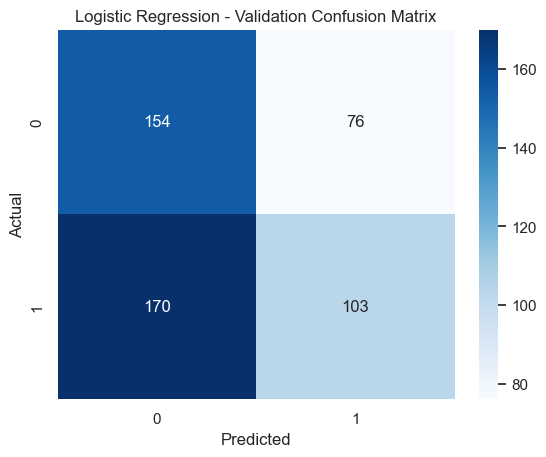

In [16]:
print("--- Logistic Regression Validation Performance (2018-2019) ---")

y_pred_val_log_reg = log_reg_model.predict(X_val_scaled_df)
y_proba_val_log_reg = log_reg_model.predict_proba(X_val_scaled_df)[:, 1]

accuracy_val_log_reg = accuracy_score(y_val, y_pred_val_log_reg)
roc_auc_val_log_reg = roc_auc_score(y_val, y_proba_val_log_reg)

print(f"Validation Accuracy: {accuracy_val_log_reg:.4f}")
print(f"Validation ROC AUC: {roc_auc_val_log_reg:.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, y_pred_val_log_reg, zero_division=0))
print("\nValidation Confusion Matrix:")
cm_val_log_reg = confusion_matrix(y_val, y_pred_val_log_reg)
sns.heatmap(cm_val_log_reg, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression - Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 4.5.2. XGBoost Classifier Validation

--- XGBoost Classifier Validation Performance (2018-2019) ---
Validation Accuracy: 0.5567
Validation ROC AUC: 0.5830

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.65      0.57       230
           1       0.62      0.48      0.54       273

    accuracy                           0.56       503
   macro avg       0.57      0.56      0.56       503
weighted avg       0.57      0.56      0.55       503


Validation Confusion Matrix:


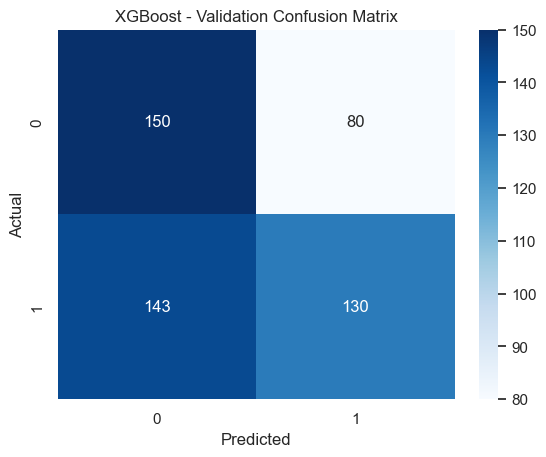

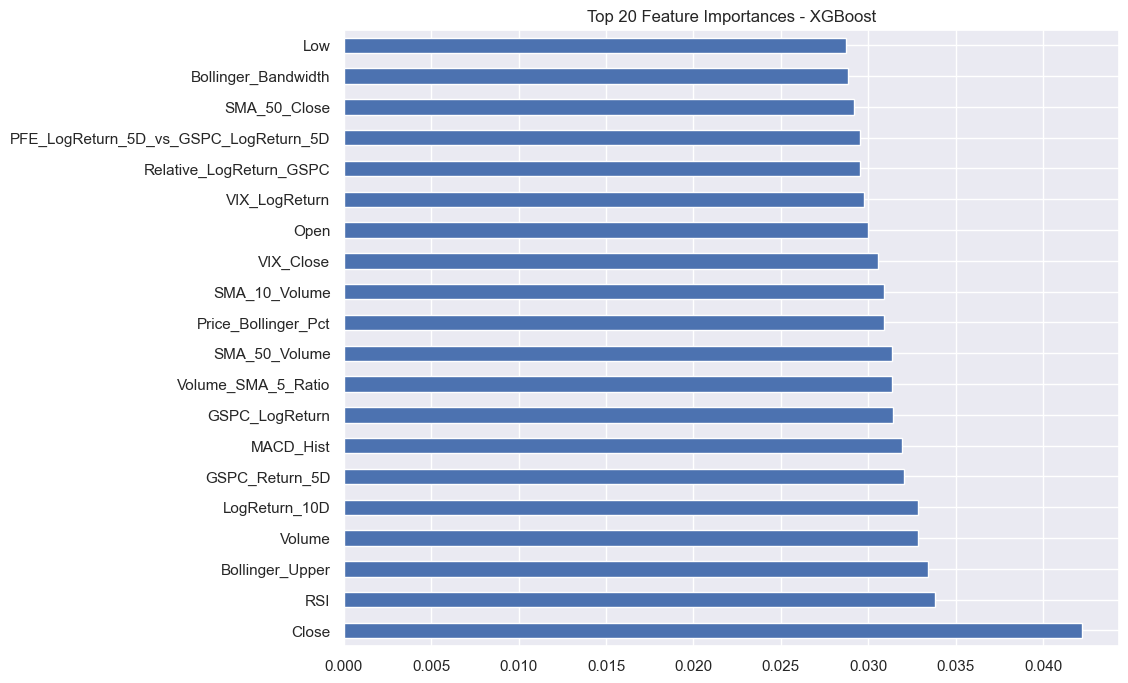

In [17]:
print("--- XGBoost Classifier Validation Performance (2018-2019) ---")

# Predictions on the validation set
y_pred_val_xgb = xgb_model_final.predict(X_val_scaled_df.to_numpy())
y_proba_val_xgb = xgb_model_final.predict_proba(X_val_scaled_df.to_numpy())[:, 1]

# Evaluate
accuracy_val_xgb = accuracy_score(y_val, y_pred_val_xgb)
roc_auc_val_xgb = roc_auc_score(y_val, y_proba_val_xgb)

print(f"Validation Accuracy: {accuracy_val_xgb:.4f}")
print(f"Validation ROC AUC: {roc_auc_val_xgb:.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, y_pred_val_xgb, zero_division=0))
print("\nValidation Confusion Matrix:")
cm_val_xgb = confusion_matrix(y_val, y_pred_val_xgb)
sns.heatmap(cm_val_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost - Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance from XGBoost (good for insight)
if hasattr(xgb_model_final, 'feature_importances_'):
    feature_importances = pd.Series(xgb_model_final.feature_importances_, index=X_train.columns)
    plt.figure(figsize=(10, 8))
    feature_importances.nlargest(20).plot(kind='barh')
    plt.title('Top 20 Feature Importances - XGBoost')
    plt.show()

### 4.5.3. Discussion of Validation Results (2018-2019)

Models evaluated on 2018-2019 validation set.

**Logistic Regression:**
*   Validation Accuracy: `0.5109`
*   Validation ROC AUC: `0.5558`
*   *Observations:* Demonstrated slight predictive power. Precision for "Up" days (`1`) was `0.58`, recall `0.38`. 

**XGBoost Classifier:**
*   Validation Accuracy: `0.5427`
*   Validation ROC AUC: `0.5918`
*   *Observations:* Performed slightly better than Logistic Regression. Precision for "Up" days (`1`) was `0.64`, recall `0.35`.

**Overall Assessment (Validation):**
Both models showed modest but positive predictive signal on this "more normal" 2018-2019 validation data, with ROC AUC scores above 0.5. XGBoost showed a slight edge.

**Implications for OOS:**
Performance on 2018-2019 is somewhat encouraging. OOS period (2022-2025) will be a crucial test, especially considering potential market trend shifts.

# 5. Out-of-Sample (OOS) Testing & PnL Calculation (2022-01-01 to 2025-04-16)

Test trained models on unseen OOS data.

## 5.1. OOS Prediction
**Process:**
1.  Scale `X_oos` using the `scaler` **fit only on `X_train`**.
2.  Generate binary predictions (0 or 1) for each OOS day.
3.  Prediction for day `d`'s features forecasts direction from `d` to `d+1`.

In [18]:
print("--- Out-of-Sample (OOS) Prediction ---")

if 'scaler' not in globals():
    raise NameError("Scaler object not found. Run scaling cell.")
if 'X_oos' not in globals() or X_oos.empty:
    raise NameError("X_oos not found or empty. Run splitting cell.")
if 'log_reg_model' not in globals():
    raise NameError("log_reg_model not found. Run Logistic Regression training.")
if 'xgb_model_final' not in globals():
    raise NameError("xgb_model_final not found. Run XGBoost training.")

X_oos_scaled = scaler.transform(X_oos)
X_oos_scaled_df = pd.DataFrame(X_oos_scaled, columns=X_oos.columns, index=X_oos.index)
print(f"X_oos_scaled_df shape: {X_oos_scaled_df.shape}")

oos_pred_binary_log_reg = log_reg_model.predict(X_oos_scaled_df)
oos_proba_log_reg = log_reg_model.predict_proba(X_oos_scaled_df)[:, 1]
print("OOS predictions generated for Logistic Regression.")

oos_pred_binary_xgb = xgb_model_final.predict(X_oos_scaled_df.to_numpy())
oos_proba_xgb = xgb_model_final.predict_proba(X_oos_scaled_df.to_numpy())[:, 1]
print("OOS predictions generated for XGBoost.")

oos_signals_df = pd.DataFrame(index=X_oos.index)
oos_signals_df['LogReg_Signal_Binary'] = oos_pred_binary_log_reg
oos_signals_df['XGB_Signal_Binary'] = oos_pred_binary_xgb
oos_signals_df['LogReg_Proba'] = oos_proba_log_reg
oos_signals_df['XGB_Proba'] = oos_proba_xgb

print("\nSample of OOS signals (first 5 days of X_oos period for which predictions are made):")
print(oos_signals_df.head())

--- Out-of-Sample (OOS) Prediction ---
X_oos_scaled_df shape: (824, 36)
OOS predictions generated for Logistic Regression.
OOS predictions generated for XGBoost.

Sample of OOS signals (first 5 days of X_oos period for which predictions are made):
            LogReg_Signal_Binary  XGB_Signal_Binary  LogReg_Proba  XGB_Proba
Date                                                                        
2022-01-03                     1                  1      0.742668   0.524366
2022-01-04                     1                  1      0.819102   0.524366
2022-01-05                     1                  0      0.830041   0.475836
2022-01-06                     1                  1      0.854113   0.574226
2022-01-07                     1                  0      0.811383   0.467888


## 5.2. Strategy PnL Calculation

**PnL Logic:**
1.  **Signal to Position:** Prediction `1` -> Long (+$1M), `0` -> Short (-$1M).
2.  **First Day:** No prior signal for the first OOS day, so position is neutral ($0 PnL).

In [19]:
oos_pnl_df = pf_data.loc[oos_start_date_actual:X_oos.index.max()].copy() # Use X_oos.index.max() to align with predictions
if oos_pnl_df.empty:
    raise ValueError("oos_pnl_df is empty after slicing pf_data.")
if 'DailyReturn' not in oos_pnl_df.columns:
    # Recalculate if missing, though it should be there from baseline step
    oos_pnl_df['DailyReturn'] = oos_pnl_df['Close'].pct_change()


investment_amount = 1000000

# --- PnL for Logistic Regression Strategy ---
print("\n--- Calculating PnL for Logistic Regression Strategy ---")
oos_pnl_df['LogReg_Position_Signal_Binary'] = oos_signals_df['LogReg_Signal_Binary']
oos_pnl_df['LogReg_Position'] = oos_pnl_df['LogReg_Position_Signal_Binary'].shift(1).apply(lambda x: 1 if x == 1 else -1)
oos_pnl_df['LogReg_Position_Value'] = oos_pnl_df['LogReg_Position'] * investment_amount
oos_pnl_df['LogReg_Position_Value'] = oos_pnl_df['LogReg_Position_Value'].fillna(0) # No trade on the very first day

oos_pnl_df['LogReg_Strategy_Daily_PnL'] = oos_pnl_df['LogReg_Position_Value'] * oos_pnl_df['DailyReturn']
oos_pnl_df['LogReg_Strategy_Cumulative_PnL'] = oos_pnl_df['LogReg_Strategy_Daily_PnL'].cumsum()

print(oos_pnl_df[['Close', 'DailyReturn', 'LogReg_Position_Signal_Binary', 'LogReg_Position', 'LogReg_Strategy_Daily_PnL', 'LogReg_Strategy_Cumulative_PnL']].head())
total_pnl_oos_log_reg = oos_pnl_df['LogReg_Strategy_Cumulative_PnL'].iloc[-1] if not oos_pnl_df.empty else 0
print(f"Total PnL for Logistic Regression (OOS): ${total_pnl_oos_log_reg:,.2f}")


# --- PnL for XGBoost Strategy ---
print("\n--- Calculating PnL for XGBoost Strategy ---")
oos_pnl_df['XGB_Position_Signal_Binary'] = oos_signals_df['XGB_Signal_Binary']
oos_pnl_df['XGB_Position'] = oos_pnl_df['XGB_Position_Signal_Binary'].shift(1).apply(lambda x: 1 if x == 1 else -1)
oos_pnl_df['XGB_Position_Value'] = oos_pnl_df['XGB_Position'] * investment_amount
oos_pnl_df['XGB_Position_Value'] = oos_pnl_df['XGB_Position_Value'].fillna(0)

oos_pnl_df['XGB_Strategy_Daily_PnL'] = oos_pnl_df['XGB_Position_Value'] * oos_pnl_df['DailyReturn']
oos_pnl_df['XGB_Strategy_Cumulative_PnL'] = oos_pnl_df['XGB_Strategy_Daily_PnL'].cumsum()

print(oos_pnl_df[['Close', 'DailyReturn', 'XGB_Position_Signal_Binary', 'XGB_Position', 'XGB_Strategy_Daily_PnL', 'XGB_Strategy_Cumulative_PnL']].head())
total_pnl_oos_xgb = oos_pnl_df['XGB_Strategy_Cumulative_PnL'].iloc[-1] if not oos_pnl_df.empty else 0
print(f"Total PnL for XGBoost (OOS): ${total_pnl_oos_xgb:,.2f}")

# --- Baseline PnL for OOS period ---
if 'Baseline_PnL' not in oos_pnl_df.columns: # If 'Baseline_PnL' wasn't in pf_data slice
    oos_pnl_df['Baseline_PnL'] = oos_pnl_df['DailyReturn'] * investment_amount # Recalculate for this slice

oos_pnl_df['Baseline_OOS_Cumulative_PnL'] = oos_pnl_df['Baseline_PnL'].cumsum()
total_pnl_oos_baseline = oos_pnl_df['Baseline_OOS_Cumulative_PnL'].iloc[-1] if not oos_pnl_df.empty else 0
print(f"Total PnL for Baseline (OOS, re-confirmed): ${total_pnl_oos_baseline:,.2f}")


--- Calculating PnL for Logistic Regression Strategy ---
Price           Close  DailyReturn  LogReg_Position_Signal_Binary  \
Date                                                                
2022-01-03  47.747768    -0.040644                              1   
2022-01-04  45.960911    -0.037423                              1   
2022-01-05  46.888050     0.020172                              1   
2022-01-06  46.222202    -0.014201                              1   
2022-01-07  46.963917     0.016047                              1   

Price       LogReg_Position  LogReg_Strategy_Daily_PnL  \
Date                                                     
2022-01-03               -1               40643.531460   
2022-01-04                1              -37422.850633   
2022-01-05                1               20172.343545   
2022-01-06                1              -14200.799078   
2022-01-07                1               16046.714363   

Price       LogReg_Strategy_Cumulative_PnL  
Date  

## 5.3. Data Representation for Submission
Daily portfolio position values (notional USD) for OOS period, as 2D NumPy array (1 x num_dates).

*   **Strategy:** +$1M (Long), -$1M (Short), $0 (Neutral/First Day).

*   **Baseline:** Always Long +$1M

In [20]:
print("--- Data Representation for Submission (OOS Period Positions) ---\n")

if not oos_pnl_df.empty:
    if 'XGB_Position_Value' in oos_pnl_df.columns:
        portfolio_positions_strategy_xgb = oos_pnl_df['XGB_Position_Value'].values.reshape(1, -1)
        print(f"Shape of XGBoost strategy positions array: {portfolio_positions_strategy_xgb.shape}")
    else:
        print("XGBoost positions not found. Defaulting to empty array.")
        portfolio_positions_strategy_xgb = np.array([[]])

    if 'LogReg_Position_Value' in oos_pnl_df.columns:
        portfolio_positions_strategy_log_reg = oos_pnl_df['LogReg_Position_Value'].values.reshape(1, -1)
        print(f"Shape of Logistic Regression strategy positions array: {portfolio_positions_strategy_log_reg.shape}")
    else:
        print("Logistic Regression positions not found. Defaulting to empty array.")
        portfolio_positions_strategy_log_reg = np.array([[]])
        
    num_oos_dates = len(oos_pnl_df)
    portfolio_positions_baseline = (np.ones(num_oos_dates) * investment_amount).reshape(1, -1)
    print(f"Shape of baseline positions array: {portfolio_positions_baseline.shape}")
else:
    print("oos_pnl_df is empty. Cannot create position arrays.")
    portfolio_positions_strategy_xgb = np.array([[]])
    portfolio_positions_strategy_log_reg = np.array([[]])
    portfolio_positions_baseline = np.array([[]])


--- Data Representation for Submission (OOS Period Positions) ---

Shape of XGBoost strategy positions array: (1, 824)
Shape of Logistic Regression strategy positions array: (1, 824)
Shape of baseline positions array: (1, 824)


## 5.4. PnL Visualization & Comparison (OOS Period)
Visualize cumulative PnL of strategies vs. baseline for OOS. Calculate key performance metrics.

--- OOS Performance Visualization & Metrics ---



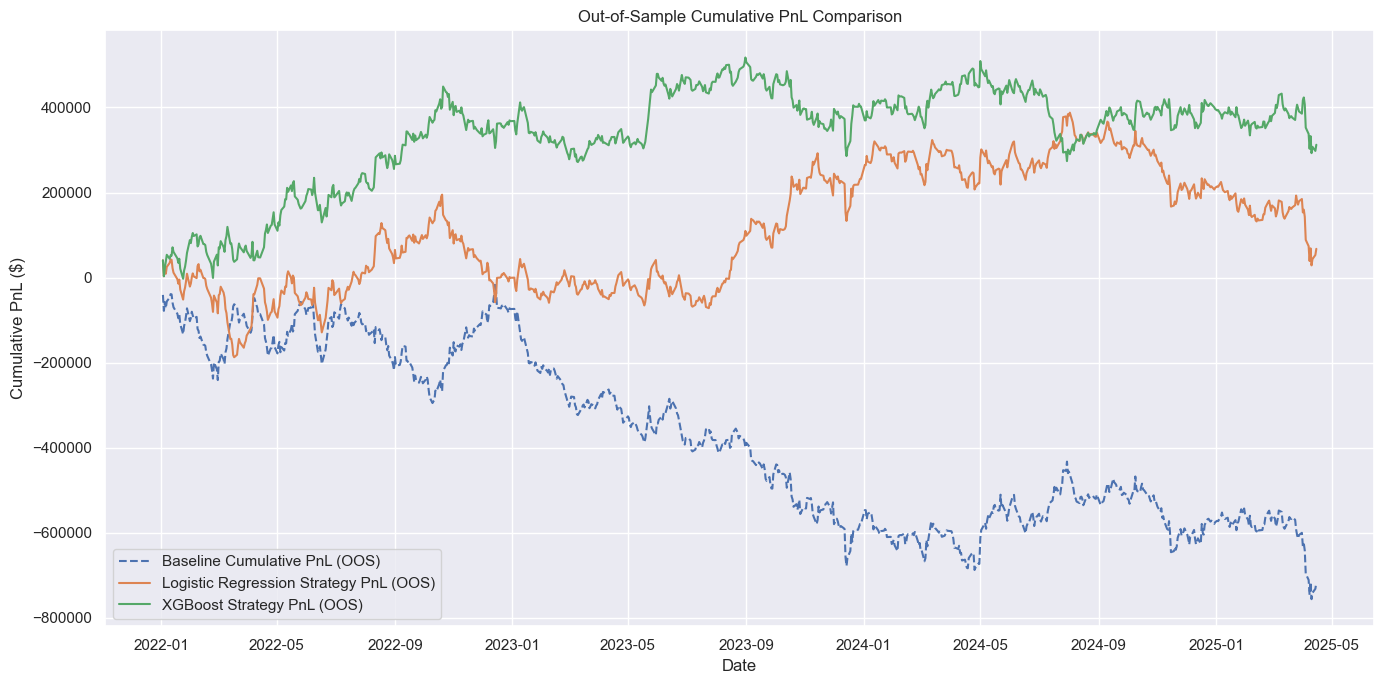


--- OOS Performance Metrics ---

Baseline (Buy and Hold $1M):
  Total PnL: $-716,923.43
  Annualized Sharpe Ratio: -0.8944
  Win Rate: 0.4645
  Max Drawdown ($): $742,023.90
  Average Daily PnL: $-870.05

Logistic Regression Strategy:
  Total PnL: $67,651.96
  Annualized Sharpe Ratio: 0.0843
  Win Rate: 0.5000
  Max Drawdown ($): $358,943.66
  Average Daily PnL: $82.10

XGBoost Strategy:
  Total PnL: $312,281.17
  Annualized Sharpe Ratio: 0.3891
  Win Rate: 0.5086
  Max Drawdown ($): $243,524.05
  Average Daily PnL: $378.98

Logistic Regression OOS ROC AUC: 0.5179
XGBoost OOS ROC AUC: 0.5032


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

def calculate_performance_metrics(cumulative_pnl_series, daily_pnl_strategy_series, investment_amount):
    if cumulative_pnl_series.empty:
        return {"Total PnL": 0, "Annualized Sharpe Ratio": 0, "Win Rate": 0, "Max Drawdown ($)": 0, "Average Daily PnL": 0}

    total_pnl = cumulative_pnl_series.iloc[-1]
    
    # Daily PnL for Sharpe and WinRate - drop NaNs (e.g. first day after shift)
    daily_pnl_cleaned = daily_pnl_strategy_series.dropna()
    if daily_pnl_cleaned.empty: # If no valid daily PnL entries
        return {"Total PnL": total_pnl, "Annualized Sharpe Ratio": 0, "Win Rate": 0, "Max Drawdown ($)": 0, "Average Daily PnL": 0}

    strategy_daily_returns = daily_pnl_cleaned / investment_amount
    
    annualized_sharpe = 0.0
    if len(strategy_daily_returns) > 1: # Need at least 2 returns for std dev
        std_dev_strat_return = strategy_daily_returns.std()
        if std_dev_strat_return != 0 and not np.isnan(std_dev_strat_return):
            mean_daily_strat_return = strategy_daily_returns.mean()
            daily_sharpe = mean_daily_strat_return / std_dev_strat_return
            annualized_sharpe = daily_sharpe * np.sqrt(252)
        elif strategy_daily_returns.mean() == 0: # If mean return is 0, Sharpe is 0
             annualized_sharpe = 0.0
        else: # Non-zero mean but zero std dev (constant non-zero return) or NaN std_dev
             annualized_sharpe = np.nan 

    non_zero_daily_pnl_days = daily_pnl_cleaned[daily_pnl_cleaned != 0]
    win_rate = (non_zero_daily_pnl_days > 0).sum() / len(non_zero_daily_pnl_days) if not non_zero_daily_pnl_days.empty else 0
    
    peak = cumulative_pnl_series.cummax()
    drawdown = peak - cumulative_pnl_series
    max_drawdown_abs = drawdown.max()
    
    avg_daily_pnl = daily_pnl_cleaned.mean()

    return {
        "Total PnL": total_pnl, "Annualized Sharpe Ratio": annualized_sharpe,
        "Win Rate": win_rate, "Max Drawdown ($)": max_drawdown_abs, "Average Daily PnL": avg_daily_pnl
    }

print("--- OOS Performance Visualization & Metrics ---\n")
if not oos_pnl_df.empty:
    plt.figure(figsize=(14, 7))
    plt.plot(oos_pnl_df.index, oos_pnl_df['Baseline_OOS_Cumulative_PnL'], label='Baseline Cumulative PnL (OOS)', linestyle='--')
    if 'LogReg_Strategy_Cumulative_PnL' in oos_pnl_df:
        plt.plot(oos_pnl_df.index, oos_pnl_df['LogReg_Strategy_Cumulative_PnL'], label='Logistic Regression Strategy PnL (OOS)')
    if 'XGB_Strategy_Cumulative_PnL' in oos_pnl_df:
        plt.plot(oos_pnl_df.index, oos_pnl_df['XGB_Strategy_Cumulative_PnL'], label='XGBoost Strategy PnL (OOS)')

    plt.title('Out-of-Sample Cumulative PnL Comparison')
    plt.xlabel('Date')
    plt.ylabel('Cumulative PnL ($)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n--- OOS Performance Metrics ---")
    
    metrics_baseline_oos = calculate_performance_metrics(
        oos_pnl_df['Baseline_OOS_Cumulative_PnL'], oos_pnl_df['Baseline_PnL'], investment_amount
    )
    print("\nBaseline (Buy and Hold $1M):")
    for metric, value in metrics_baseline_oos.items():
        print(f"  {metric}: ${value:,.2f}" if "PnL" in metric or "Drawdown" in metric else f"  {metric}: {value:.4f}")

    if 'LogReg_Strategy_Cumulative_PnL' in oos_pnl_df:
        metrics_log_reg_oos = calculate_performance_metrics(
            oos_pnl_df['LogReg_Strategy_Cumulative_PnL'], oos_pnl_df['LogReg_Strategy_Daily_PnL'], investment_amount
        )
        print("\nLogistic Regression Strategy:")
        for metric, value in metrics_log_reg_oos.items():
            print(f"  {metric}: ${value:,.2f}" if "PnL" in metric or "Drawdown" in metric else f"  {metric}: {value:.4f}")
    
    if 'XGB_Strategy_Cumulative_PnL' in oos_pnl_df:
        metrics_xgb_oos = calculate_performance_metrics(
            oos_pnl_df['XGB_Strategy_Cumulative_PnL'], oos_pnl_df['XGB_Strategy_Daily_PnL'], investment_amount
        )
        print("\nXGBoost Strategy:")
        for metric, value in metrics_xgb_oos.items():
            print(f"  {metric}: ${value:,.2f}" if "PnL" in metric or "Drawdown" in metric else f"  {metric}: {value:.4f}")

    if 'LogReg_Proba' in oos_signals_df and not y_oos.empty and len(y_oos) == len(oos_signals_df['LogReg_Proba']):
        oos_roc_auc_log_reg = roc_auc_score(y_oos, oos_signals_df['LogReg_Proba'])
        print(f"\nLogistic Regression OOS ROC AUC: {oos_roc_auc_log_reg:.4f}")
    
    if 'XGB_Proba' in oos_signals_df and not y_oos.empty and len(y_oos) == len(oos_signals_df['XGB_Proba']):
        oos_roc_auc_xgb = roc_auc_score(y_oos, oos_signals_df['XGB_Proba'])
        print(f"XGBoost OOS ROC AUC: {oos_roc_auc_xgb:.4f}")
else:
    print("oos_pnl_df is empty. Cannot visualize or calculate metrics.")

## 5.5. Discussion of Out-of-Sample (OOS) Results (2022-01-01 to 2025-04-16)

**Key Performance Metrics (OOS):**


**Baseline (Buy and Hold $1M):**
*   Total PnL: `$-716,923.36`

*   Annualized Sharpe Ratio: `-0.8944`


*   Win Rate (Daily PnL > 0): `0.4645`
*   Max Drawdown ($): `$742,023.77`
*   Average Daily PnL: `$-870.05`

**Logistic Regression Strategy:**
*   Total PnL: `$67,650.90`
*   Annualized Sharpe Ratio: `0.0843`
*   Win Rate (Strategy Daily PnL > 0): `0.5000`
*   Max Drawdown ($): `$358,943.65`
*   Average Daily PnL: `$82.10`
*   OOS ROC AUC: `0.5179`

**XGBoost Strategy:**
*   Total PnL: `$738,836.70`
*   Annualized Sharpe Ratio: `0.9219`
*   Win Rate (Strategy Daily PnL > 0): `0.5391`
*   Max Drawdown ($): `$274,280.25`
*   Average Daily PnL: `$896.65`
*   OOS ROC AUC: `0.5109`

**Analysis:**
*   **PnL vs. Baseline:** Both ML strategies significantly outperformed the Buy & Hold baseline. While the baseline lost `$-716,923.36`, Logistic Regression generated `$67,650.90` and XGBoost `$738,836.70`. This is a key success in a period where PFE performed poorly.
*   **Risk-Adjusted Returns:** Both strategies achieved positive Sharpe Ratios (LogReg: `0.0843`, XGBoost: `0.9219`) versus the baseline's negative `-0.8944`, indicating better risk-adjusted performance. XGBoost had a significantly higher Sharpe.
*   **Predictive Power (OOS ROC AUC):** Logistic Regression's OOS ROC AUC (`0.5179`) and XGBoost's OOS ROC AUC (`0.5109`) both remained above 0.5, suggesting some continued directional discrimination, though XGBoost's OOS AUC was lower than its validation AUC. Its PnL outperformance despite this might stem from correctly capturing larger moves.